In [1]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import shap
from catboost import CatBoostClassifier

C:\Users\littl\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_catboost_grid_search(data: pd.DataFrame,
                             target: str,
                             drop_threshold: float = 0.75,
                             max_iter_mice: int = 12,
                             n_splits: int = 5,
                             random_state: int = 42):
    """
    Perform CatBoost grid search with MICE imputation, then output top 15 models'
    confusion matrices and classification reports. Also output feature importances
    and SHAP values for the best model.

    :param data: Input dataframe including the target column.
    :param target: Name of the target column.
    :param drop_threshold: Rows with missing ratio above this will be dropped (default=0.95).
    :param max_iter_mice: Iterations for IterativeImputer (MICE) (default=12).
    :param n_splits: Number of folds for cross-validation (default=5).
    :param random_state: Seed for reproducibility (default=42).
    :return: (best_model, best_params) — The best CatBoostClassifier model and its best hyperparameters.
    """
    # 1. Drop rows with too many missing values
    row_missing_ratio = data.isnull().sum(axis=1) / data.shape[1]
    data_cleaned = data.loc[row_missing_ratio <= drop_threshold].copy()
    
    # 2. Separate features (X) and target (y)
    y = data_cleaned[target]
    X = data_cleaned.drop(columns=[target])
    feature_names = X.columns  # Keep feature names for later use

    # 3. MICE imputation
    imputer = IterativeImputer(max_iter=max_iter_mice, random_state=random_state)
    X_imputed = imputer.fit_transform(X)
    
    # Define a parameter grid for CatBoostClassifier
    param_grid = {
        "iterations": [300],
        "learning_rate": [0.05],
        "depth": [4],
        "l2_leaf_reg": [3],
        "border_count": [64]
    }
    
    # Initialize the base model
    catboost = CatBoostClassifier(random_state=random_state, verbose=0)
    
    # 4. Grid Search with StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=catboost,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_imputed, y)

    # Print the best hyperparameters and score
    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score (accuracy):", grid_search.best_score_)
    
    # Retrieve the best estimator
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # 5. Retrieve top 15 results and evaluate
    print("\n== Top 15 Parameter Sets and Their Scores ==")
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)
    
    top_15 = cv_results.head(15).copy()
    for rank, (_, row) in enumerate(top_15.iterrows(), start=1):
        print(f"\nRank {rank}:")
        print("Params:", row["params"])
        print("Mean CV Score:", row["mean_test_score"])
        
        # Re-train model on entire dataset with these params
        params = row["params"]
        model = CatBoostClassifier(random_state=random_state, verbose=0, **params)
        model.fit(X_imputed, y)
        
        # Predict on the same data (X_imputed) for demonstration
        y_pred = model.predict(X_imputed)
        
        # Print confusion matrix and classification report
        print("\nConfusion Matrix:")
        print(confusion_matrix(y, y_pred))
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

    # 6. Print the feature importances of the best model
    print("\n== Best Model Feature Importances ==")
    importances = best_model.get_feature_importance()
    feat_imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    print(feat_imp_df.to_string(index=False))
    
    # 7. Compute and visualize SHAP values for the best model
    print("\n== Computing SHAP values for the best model ==")
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_imputed)
    
    # Summary plot (if running in a notebook, this will display inline)
    shap.summary_plot(shap_values, X_imputed, feature_names=feature_names)

    return best_model, best_params


In [3]:
def feature_selection_with_catboost(data: pd.DataFrame,
                                    target: str,
                                    best_params: dict,
                                    drop_threshold: float = 0.75,
                                    max_iter_mice: int = 12,
                                    n_splits: int = 5,
                                    random_state: int = 42):
    """
    Re-train CatBoost with only the top X% features by importance, where X goes from 10% to 50%
    in steps of 5%. Evaluate each sub-model via cross-validation (accuracy) and print results.

    :param data: The original DataFrame including the target column.
    :param target: Name of the target column.
    :param best_params: A dict of hyperparameters (e.g., from a previous grid search).
    :param drop_threshold: Rows with missing ratio above this will be dropped (default=0.95).
    :param max_iter_mice: Iterations for IterativeImputer (MICE) (default=12).
    :param n_splits: Number of folds for cross-validation (default=5).
    :param random_state: Seed for reproducibility (default=42).
    :return: None (prints out results of feature selection).
    """
    # Step 1. Clean data by dropping rows with many missing values
    row_missing_ratio = data.isnull().sum(axis=1) / data.shape[1]
    data_cleaned = data.loc[row_missing_ratio <= drop_threshold].copy()
    
    # Step 2. Separate features and target
    y = data_cleaned[target]
    X = data_cleaned.drop(columns=[target])
    feature_names = X.columns

    # Step 3. Impute missing values using MICE
    imputer = IterativeImputer(max_iter=max_iter_mice, random_state=random_state)
    X_imputed = imputer.fit_transform(X)

    # Step 4. Train a CatBoost model with best_params on entire data to get feature importances
    base_model = CatBoostClassifier(verbose=0, random_state=random_state, **best_params)
    base_model.fit(X_imputed, y)
    importances = base_model.get_feature_importance()
    
    # Sort features by importance (descending)
    feat_imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # For convenience, get sorted feature names
    sorted_features = feat_imp_df["Feature"].tolist()

    # Step 5. For coverage from 10% to 50% in increments of 5%, select top features and re-train
    n_total_features = len(feature_names)
    
    results = []
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for coverage in range(10, 81, 5):
        # Compute how many features to keep
        n_keep = max(1, int(np.ceil(n_total_features * (coverage / 100.0))))
        
        # Select top n_keep features
        selected_feats = sorted_features[:n_keep]

        # Build a subset of X_imputed with only those features
        # Need to map from original columns to their indices
        selected_indices = [feature_names.get_loc(feat) for feat in selected_feats]
        X_sub = X_imputed[:, selected_indices]

        # Re-train CatBoost on these top features using cross-validation
        model = CatBoostClassifier(verbose=0, random_state=random_state, **best_params)
        scores = cross_val_score(model, X_sub, y, cv=cv, scoring="accuracy", n_jobs=-1)
        
        mean_acc = scores.mean()
        std_acc = scores.std()

        results.append({
            "Coverage(%)": coverage,
            "Num_Features": n_keep,
            "Mean_Accuracy": mean_acc,
            "Std_Accuracy": std_acc
        })

    # Step 6. Print results
    results_df = pd.DataFrame(results)
    print("\n=== Feature Selection Results (Top X% of Features) ===")
    print(results_df.to_string(index=False))

In [4]:
def main():
    """
    Main function for demonstration.
    Modify the CSV path, target column name as needed.
    """
    # Example: read data
    data = pd.read_csv(r"../data/final/nicu_30.csv")

    # Remove ID column if necessary
    # e.g., data = data.drop(columns=["SUBJECT_ID"])

    # Define target column
    target_column = "is_infected"

    # 1. Run grid search for CatBoost
    best_model, best_params = run_catboost_grid_search(
        data=data,
        target=target_column,
        drop_threshold=0.75,
        max_iter_mice=12
    )
    # Suppose best_params is: {'border_count': 32, 'depth': 4, 'iterations': 300,
    #                          'l2_leaf_reg': 1, 'learning_rate': 0.05}

    print("\nFinal Best CatBoost Model:")
    print(best_model)

    # 2. Feature selection based on best_params
    feature_selection_with_catboost(
        data=data,
        target=target_column,
        best_params=best_params,
        drop_threshold=0.75,
        max_iter_mice=12
    )

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'border_count': 64, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Best CV Score (accuracy): 0.7853784815388686

== Top 15 Parameter Sets and Their Scores ==

Rank 1:
Params: {'border_count': 64, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Mean CV Score: 0.7853784815388686

Confusion Matrix:
[[ 542  318]
 [  95 1864]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.63      0.72       860
         1.0       0.85      0.95      0.90      1959

    accuracy                           0.85      2819
   macro avg       0.85      0.79      0.81      2819
weighted avg       0.85      0.85      0.85      2819


== Best Model Feature Importances ==
                     Feature  Importance
                 SaO2_min_30    4.482195
                SaO2_mean_30    4.193623
         Lymphocytes_mean_30    3.5120

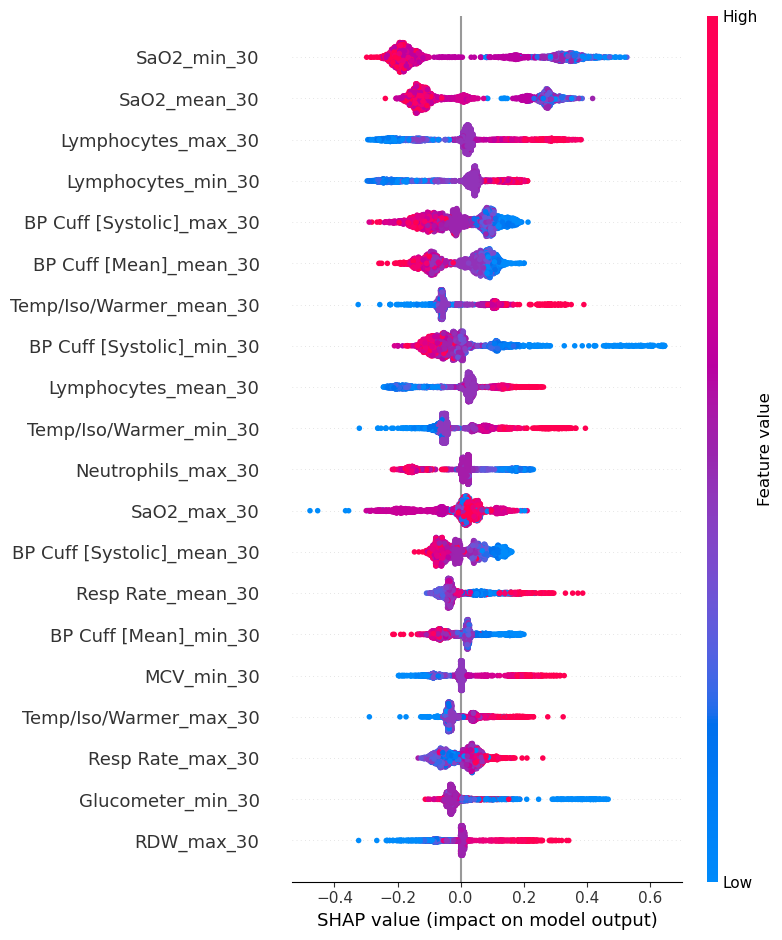


Final Best CatBoost Model:

=== Feature Selection Results (Top X% of Features) ===
 Coverage(%)  Num_Features  Mean_Accuracy  Std_Accuracy
          10             9       0.775095      0.013144
          15            13       0.778286      0.010604
          20            17       0.777932      0.007503
          25            22       0.782545      0.007017
          30            26       0.783961      0.013272
          35            30       0.784673      0.013429
          40            34       0.789280      0.010742
          45            39       0.784671      0.011565
          50            43       0.784670      0.011578
          55            47       0.781480      0.008185
          60            51       0.787511      0.014021
          65            56       0.786800      0.013858
          70            60       0.784317      0.010877
          75            64       0.789282      0.015499
          80            68       0.787864      0.011764


In [5]:
if __name__ == "__main__":
    main()